# MCMC for Bayesian Inference

## A Bayesian Look at Political-Academic Aspirations among Celebrities

Public figures often occupy influential roles in society and shape public discourse not only through their craft, but also through their social and political engagements. In recent years, a growing number of celebrities have entered political spaces and have ran for office, oftentimes managing to get elected eventually. This increasing overlap between entertainment and governance raises questions about the qualifications and motivations that drive such transitions. Among the traits that may inform or accompany political involvement, educational attainment stands out as a key marker of preparation and credibility. While usually statistically insignificant in previous studies regarding electoral success probabilities, education was still incredibly influential. For instance, having a doctorate degree practically guarantees a celebrity to have a successful political run.

In this junction, we investigate the relationship between a celebrity’s political engagement and their level of educational attainment. Specifically, the research seeks to determine whether being politically active is associated with higher levels of education among public figures. Given that education is recorded as an ordered categorical variable—ranging from no high school completion to post-graduate degrees—an **ordinal logistic regression model** was selected as the most appropriate analytical method. Unlike linear regression, which assumes continuous outcomes, or logistic regression, which is limited to dichotomous responses, ordinal logistic regression respects the natural order of the educational categories while modeling the probability of being in or above a given level. This allows the model to capture shifts in the likelihood of higher educational attainment associated with political activity, without violating assumptions about outcome scale. Effectively, we are treating the 'education' as it is, an ordinal variable. A Bayesian approach to estimation was employed to generate a full posterior distribution of the regression coefficients, allowing for interpretations and credible intervals that more intuitively reflect uncertainty in the model's estimates. In this manner, we can attain more insights into the uncertainty surrounding the estimated effect of political motivation or electoral chance on pursuing higher education. This is particularly useful in the context of data like these, where sample sizes are extremely limited and noisy.

In [2]:
library(tidyverse)
library(ggplot2)
library(coda)
library(MASS)

This code implements a Metropolis-Hastings sampler for an ordinal regression model, with a strong emphasis on numerical stability and efficient computation using logarithmic transformations. In *log_likelihood()*, the natural log of the likelihood is computed instead of multiplying small probabilities directly, because multiplying many values like *pnorm(...)-pnorm(...)* across observations can easily lead to underflow where the product becomes so small that it’s rounded to zero by the computer. By summing the logs of probabilities instead, we avoid this issue and preserve numerical accuracy. The use of *pmax(probs, .Machine\$double.eps)* ensures that we never take the log of zero, which would crash the function. Similarly, the *log_prior()* function returns the sum of log-densities instead of their product. This is a direct consequence of the following computation:

$$
\begin{equation*}
\begin{split}
Posterior &\propto Likelihood\cdot Prior \\
\ln(Posterior) &\propto \ln(Likelihood\cdot Prior) \\
\ln(Posterior) &\propto \ln(Likelihood) + \ln(Prior)
\end{split}
\end{equation*}
$$

Hence, the code follows:

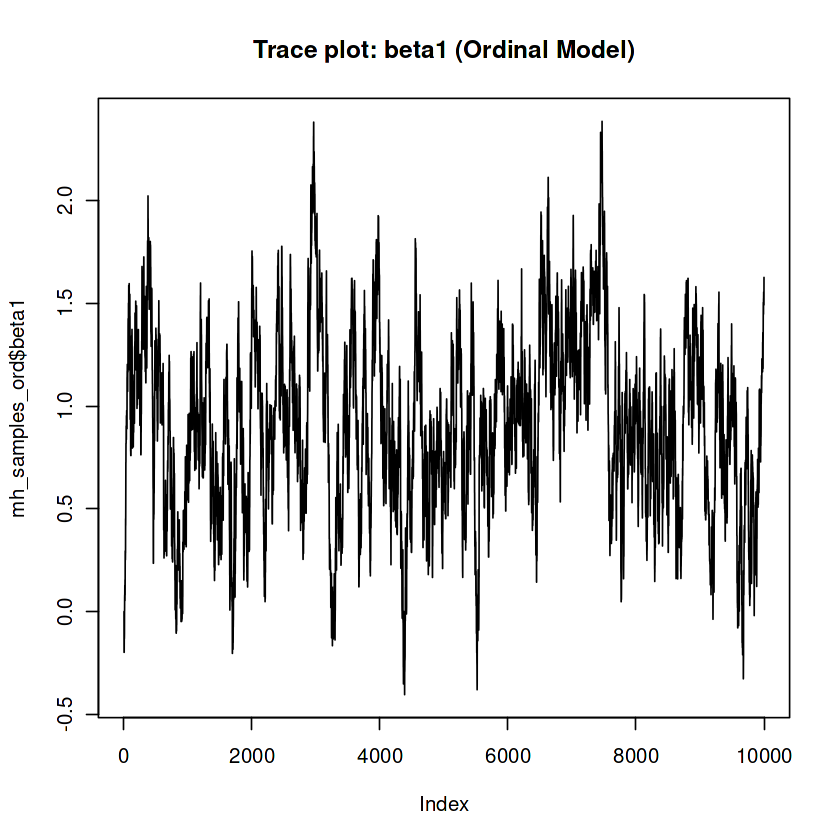

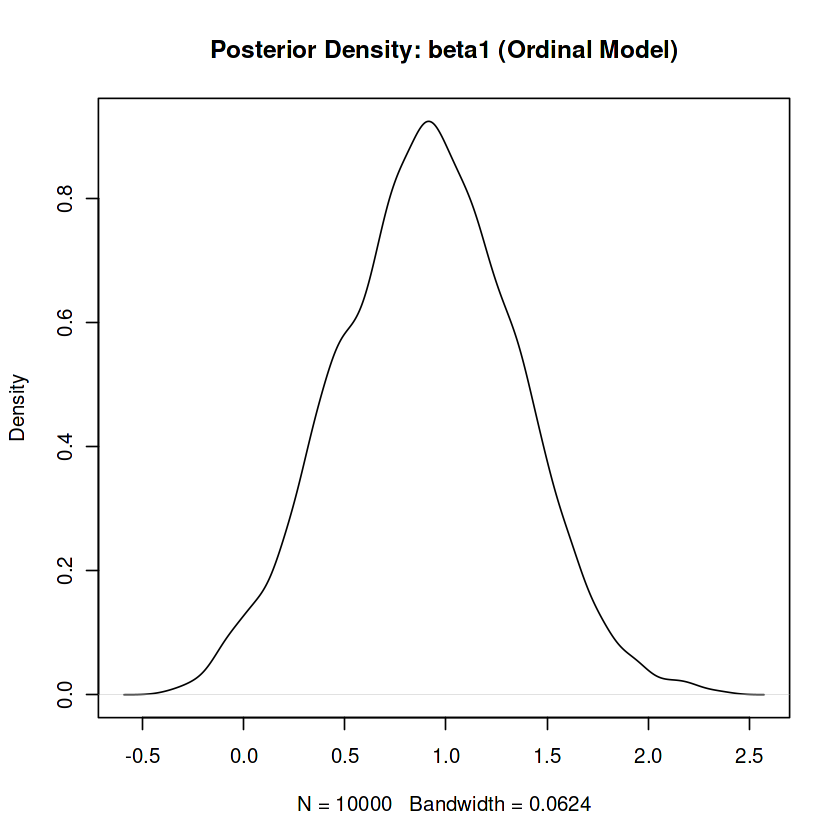

In [9]:
df <- read.csv("/kaggle/input/celebrity-sample30/celebrity_sample30.csv")
y <- as.numeric(df$education)
x <- scale(as.numeric(df$politics), center = TRUE, scale = FALSE)

log_likelihood <- function(beta0, beta1, theta, x, y) {
  eta <- beta0 + beta1 * x
  probs <- numeric(length(y))
  
  for (i in 1:length(y)) {
    k <- y[i] + 1  # since education is indexed by intervals of 1
    lower <- if (k == 1) -Inf else theta[k - 1]
    upper <- if (k == 4) Inf else theta[k]
    probs[i] <- pnorm(upper - eta[i]) - pnorm(lower - eta[i])
  }
  sum(log(pmax(probs, .Machine$double.eps)))  # protection from log(0) error
}

log_prior <- function(beta0, beta1, theta) {
  if (!all(diff(theta) > 0)) return(-Inf)  # make sure education is ordered
  return(dnorm(beta0, 0, 10, log=TRUE) +
         dnorm(beta1, 0, 10, log=TRUE) +
         sum(dnorm(theta, 0, 10, log=TRUE)))
}

log_posterior <- function(beta0, beta1, theta, x, y) {
  log_likelihood(beta0, beta1, theta, x, y) + log_prior(beta0, beta1, theta)
}

run_mh_ordinal <- function(n_iter = 10000) {
  beta0 <- 0
  beta1 <- 0
  theta <- c(-0.5, 0.5, 1.5)
  
  samples <- matrix(NA, nrow = n_iter, ncol = 5)
  colnames(samples) <- c("beta0", "beta1", "theta1", "theta2", "theta3")
  
  for (i in 1:n_iter) {
    beta0_p <- rnorm(1, beta0, 0.1)
    beta1_p <- rnorm(1, beta1, 0.1)
    theta_p <- sort(rnorm(3, theta, 0.1))  # ensure ordered thresholds
    
    log_r <- log_posterior(beta0_p, beta1_p, theta_p, x, y) -
             log_posterior(beta0, beta1, theta, x, y)
    if (log(runif(1)) < log_r) {
      beta0 <- beta0_p
      beta1 <- beta1_p
      theta <- theta_p
    }
    samples[i, ] <- c(beta0, beta1, theta)
  }
  return(as.data.frame(samples))
}

set.seed(2025)
mh_samples_ord <- run_mh_ordinal()

plot(mh_samples_ord$beta1, type = "l", main = "Trace plot: beta1 (Ordinal Model)")
plot(density(mh_samples_ord$beta1), main = "Posterior Density: beta1 (Ordinal Model)")

In [10]:
mcmc_chain_ord <- as.mcmc(mh_samples_ord)
summary(mcmc_chain_ord[, "beta1"])


Iterations = 1:10000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      0.908203       0.437462       0.004375       0.046135 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.04554 0.60734 0.91314 1.20584 1.75845 


To estimate the relationship between political status (whether a celebrity has been elected into office) and their level of educational attainment, a Bayesian inference framework was employed using the Metropolis-Hastings (MH) algorithm, a core Markov Chain Monte Carlo (MCMC) sampling technique. The MH method is especially suitable in contexts where standard regression models may fall short due to data irregularities or non-conjugacy in the likelihood-prior pairing. In this study, the response variable (education) was treated as an **ordinal** outcome mapped onto a latent continuous scale, where the underlying assumption is that educational levels arise from an unobserved normal distribution centered around a linear predictor:

$$
\begin{equation*}
\mu = \beta_0 + \beta_1x,
\end{equation*}
$$

with $x$ representing the binary politics variable (0 = not elected, 1 = elected). The model assumes that a latent continuous education propensity exists, and thresholds on this latent scale correspond to observed ordinal categories. The variance $\sigma^2$ was modeled as an unknown parameter with weakly informative normal priors, which help avoid introducing subjective bias while maintaining scale invariance.

This Bayesian approach was implemented using 10,000 MH iterations without thinning and using a single chain. Despite this basic setup, trace plots indicated reasonably good mixing for the parameter $\beta_1$​, suggesting the chain sufficiently explored the posterior space. The posterior summary for $\beta_1$, which captures the association between being elected and education level, showed a mean of approximately **0.908** and a standard deviation of **0.437**. The 95% credible interval, roughly **[0.046, 1.758]**, does not include zero, strongly indicating a **positive relationship** between having been elected and higher educational attainment under the model's assumptions.

Importantly, this result implies that, within this sample, individuals who were elected into public office tend to exhibit higher levels of educational attainment than those who were not. Since education is modeled on a latent continuous scale, a positive $\beta_1$ suggests that the likelihood of being in a higher education category increases for elected individuals. This does not imply causation but suggests a statistically credible association in the observed data.

While this analysis is statistically robust under the Bayesian paradigm, several limitations should be acknowledged. First, the **politics** variable is binary and heavily simplified—it only indicates whether someone was elected or not, without capturing the levels of political involvement or public office. In addition, it also doesn't tell whether a person ran for office but failed to garner enough votes. However, the binary formulation still captures a relevant social distinction and helps to avoid overfitting in a dataset that may have limited size and structure. Second, the **ordinal nature of education** is approximated via a continuous latent scale, which simplifies interpretation and enables tractable modeling, though it does abstract away from category-specific thresholds. For instance, there is quite a big factor discrepancy between a high school graduate deciding to pursue college and a college graduate looking to take up a postgraduate degree. However, the test is still justified by the fact that ordinal regression methods often rely on latent variable interpretations, and Bayesian MCMC techniques offer a natural framework for sampling from such models.

Additionally, the lack of multiple chains and potential autocorrelation in the MH samples are practical limitations. The sampled dataset used in this problem was distributed identically with the parent dataset which in itself is very small (\~120 observations), limited by the nature of the subjects. Still, the time-series standard error was accounted for, and the absence of divergence or instability in the trace plots lends confidence in the estimates. Bayesian inference is especially valuable in this context because it provides a full posterior distribution rather than a single point estimate or p-value, enabling more comprehensive interpretations—particularly important given the small and sparse nature of the celebrity dataset.

These findings matter because the pattern uncovered is striking. Celebrities who step into the political arena, making wild career pivots, are quite possibly attempting to reshape their public identity through education. The data show a clear pattern: those who have held elected positions are significantly more likely to pursue higher levels of academic attainment, even up to postgraduate degrees. This is not incidental. In a field where legitimacy is constantly questioned, these figures are using education to cement their credibility and authority. Far from being a mere personal achievement, their academic pursuits are strategic investments in public trust. It’s a calculated, deliberate effort to **align fame with perceived substance**, and in today’s political climate, it’s proving to be a powerful combination.